# Task 2 Experimentation and uplift testing

In the task 2, we need to select the control stores and assessment of trial, finally we need to collate findings. 

In [1]:
#Import neccessary libraries
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 

In [2]:
#Load the dataset
qvi=pd.read_csv('QVI_data.csv')
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
#Check the infomation of the data
qvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
#Change the DATE datatype to Datetime
qvi.DATE=pd.to_datetime(qvi.DATE)

## Define Metrics 

The store trial was performed in stores 77,86 and 88. Firstly, we need to select the control stores which need us to explore the data and define metrics.
The trial period is start of February 2019 to the end of April 2019
We need to compare trial stores to control stores that are similar pre-trial, the similarity measurements are:
* Monthly overall sales revenue
* Monthly number of customers
* Monthly number of transactions per customer 

In [5]:
qvi['YEAR_MONTH']=qvi['DATE'].dt.strftime('%Y%m').astype('int')

In [6]:
#Define the metrics 
def store_monthly_metrics():
    store_monthly_group=qvi.groupby(['STORE_NBR','YEAR_MONTH'])
    tot_Sales=store_monthly_group['TOT_SALES'].sum()
    nCustomers=store_monthly_group['LYLTY_CARD_NBR'].nunique()
    nTxnPerCust=store_monthly_group.size()/nCustomers
    nChipsPerTxn=store_monthly_group['PROD_QTY'].sum()/store_monthly_group.size()
    avgPricePerUnit=tot_Sales/store_monthly_group['PROD_QTY'].sum()
    data=[tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit]
    headers=["tot_Sales","nCustomers","nTxnPerCust","nChipsPerTxn","avgPricePerUnit"]
    metrics=pd.concat(data,axis=1,keys=headers)
    return metrics

In [7]:
qvi_monthly_metrics =store_monthly_metrics().reset_index()
qvi_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YEAR_MONTH       3169 non-null   int64  
 2   tot_Sales        3169 non-null   float64
 3   nCustomers       3169 non-null   int64  
 4   nTxnPerCust      3169 non-null   float64
 5   nChipsPerTxn     3169 non-null   float64
 6   avgPricePerUnit  3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


In [8]:
#Filter to the pre-trail period and stores with full observation periods
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEAR_MONTH"] < 201902]
pretrial_full_observ.head(8)

,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
5,1,201812,189.6,42,1.119048,1.212766,3.326316
6,1,201901,154.8,35,1.028571,1.166667,3.685714
12,2,201807,150.8,39,1.051282,1.121951,3.278261


## Select control Stores

In [9]:
#Calculate the metrics corrlation between trial store and control store
def calCorrelation(metric, trialstore, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    output= pd.DataFrame(columns=["Trial_Str", "Ctrl_Str", "Correlation"])
    trial_store = inputTable[inputTable["STORE_NBR"] == trialstore][metric].reset_index()
    for control in control_store_nbrs:
        control_store = inputTable[inputTable["STORE_NBR"] == control][metric].reset_index()
        concat_df = pd.DataFrame(columns = ["Trial_Str", "Ctrl_Str", "Correlation"])
        concat_df["Correlation"] = trial_store.corrwith(control_store, axis=1)
        concat_df["Trial_Str"] = trialstore
        concat_df["Ctrl_Str"] = control
        output =pd.concat([output, concat_df])
    return output

In [10]:
#Caculate the standardised magnitude difference between trial store and control 
def calMagnitudeDistance(metric,trialstore,inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    output= pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == trialstore][metric].reset_index(drop=True)
    for control in control_store_nbrs:
        control_store = inputTable[inputTable["STORE_NBR"] == control][metric].reset_index(drop=True)
        concat_df=abs(trial_store-control_store)
        concat_df["Trial_Str"] = trialstore
        concat_df["Ctrl_Str"] = control                 
        output =pd.concat([output, concat_df])
    for col in metric:
        output[col] = 1 - ((output[col] - output[col].min()) / (output[col].max() -output[col].min()))
    output["magnitude"] = output[metric].mean(axis=1)
    return output                  

In [11]:
#Calculate the correlation between the trial store and control store
corr_table=pd.DataFrame()
for trialstore in [77,86,88]:
    corr_table=pd.concat([corr_table,calCorrelation(["tot_Sales", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"],trialstore)])
corr_table.head()

,Trial_Str,Ctrl_Str,Correlation
0,77,1,0.070544
1,77,1,0.027332
2,77,1,0.002472
3,77,1,-0.019991
4,77,1,0.030094


In [12]:
#calculate the standardised magnitude difference between the trial store and control store 
dist_table=pd.DataFrame()
for trialstore in [77,86,88]:
    dist_table=pd.concat([corr_table,calMagnitudeDistance(["tot_Sales", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"],trialstore)])
dist_table.head()

,Trial_Str,Ctrl_Str,Correlation,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,magnitude
0,77,1,0.070544,NaN,NaN,NaN,NaN,NaN,NaN
1,77,1,0.027332,NaN,NaN,NaN,NaN,NaN,NaN
2,77,1,0.002472,NaN,NaN,NaN,NaN,NaN,NaN
3,77,1,-0.019991,NaN,NaN,NaN,NaN,NaN,NaN
4,77,1,0.030094,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#combine the correlation and magnitude distance 
def combine_corr_dist(metric, trialstore, inputTable=pretrial_full_observ):
    corrs = calCorrelation(metric, trialstore, inputTable)
    dists = calMagnitudeDistance(metric, trialstore, inputTable)
    dists = dists.drop(metric, axis=1)
    combine = pd.merge(corrs, dists, on=["Trial_Str", "Ctrl_Str"])
    return combine


In [14]:
compare_sales_table=pd.DataFrame()
for trialstore in [77, 86, 88]:
    compare_sales_table= pd.concat([compare_sales_table, combine_corr_dist(["tot_Sales"], trialstore)])

In [15]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [16]:
#Top Composite Score for Trial Store based on TOT_SALES
grouped_compsales_table = compare_sales_table.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_compsales_table["CompScore"] = (corr_weight *grouped_compsales_table["Correlation"]) + (dist_weight * grouped_compsales_table["magnitude"])
for trialstore in compare_sales_table["Trial_Str"].unique():
    print(grouped_compsales_table[grouped_compsales_table["Trial_Str"] == trialstore].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Correlation  magnitude  CompScore
218         77       233          1.0   0.986477   0.993238
239         77       255          1.0   0.979479   0.989739
177         77       188          1.0   0.977663   0.988831
49          77        53          1.0   0.976678   0.988339
120         77       131          1.0   0.976267   0.988134 

     Trial_Str  Ctrl_Str  Correlation  magnitude  CompScore
356         86       109          1.0   0.966783   0.983391
401         86       155          1.0   0.965876   0.982938
464         86       222          1.0   0.962280   0.981140
467         86       225          1.0   0.960512   0.980256
471         86       229          1.0   0.951704   0.975852 

     Trial_Str  Ctrl_Str  Correlation  magnitude  CompScore
551         88        40          1.0   0.941165   0.970582
538         88        26          1.0   0.904377   0.952189
582         88        72          1.0   0.903800   0.951900
517         88         4          1.

In [17]:
compare_customers_table = pd.DataFrame()
for trialstore in [77, 86, 88]:
    compare_customers_table = pd.concat([compare_customers_table, combine_corr_dist(["nCustomers"], trialstore)])


In [18]:
#Top Composite Score for each Trial Store based on Customers
grouped_compcustomers_table = compare_customers_table.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_compcustomers_table["CompScore"] = (corr_weight * grouped_compcustomers_table["Correlation"]) + (dist_weight * grouped_compcustomers_table["magnitude"])
for trialstore in compare_customers_table["Trial_Str"].unique():
    print(grouped_compcustomers_table[grouped_compcustomers_table["Trial_Str"] == trialstore].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Correlation  magnitude  CompScore
218         77       233          1.0   0.993132   0.996566
38          77        41          1.0   0.976648   0.988324
101         77       111          1.0   0.968407   0.984203
105         77       115          1.0   0.967033   0.983516
15          77        17          1.0   0.965659   0.982830 

     Trial_Str  Ctrl_Str  Correlation  magnitude  CompScore
401         86       155          1.0   0.986772   0.993386
356         86       109          1.0   0.969577   0.984788
467         86       225          1.0   0.969577   0.984788
471         86       229          1.0   0.964286   0.982143
293         86        39          1.0   0.961640   0.980820 

     Trial_Str  Ctrl_Str  Correlation  magnitude  CompScore
736         88       237          1.0   0.987818   0.993909
705         88       203          1.0   0.944629   0.972315
551         88        40          1.0   0.942414   0.971207
668         88       165          1.

In [19]:
#Top Similarity Based on totsales and customers
for trialstore in compare_customers_table["Trial_Str"].unique():
    a =grouped_compsales_table[grouped_compsales_table["Trial_Str"] == trialstore].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b =grouped_compcustomers_table[grouped_compcustomers_table["Trial_Str"] == trialstore].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')


Trial_Str  Ctrl_Str
77         233         0.994902
           41          0.986020
           46          0.984762
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.988162
           109         0.984090
           225         0.982522
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.970895
           26          0.958929
           72          0.954079
dtype: float64 



Based on the highest average composite score of total sales and number of customers,for trial store 77 we will chose the store 233 as control store, for trial store 86 we will chose the store 155 as control store, for trial store 88 we will chose the store 40 as control store.

Now we need to check visually if the drivers are indeed similar in the period before the trial,first check the trial store 77 with total sales

In [20]:
# Create a new dataframe 'pastSales'
pastSales= pretrial_full_observ
#Create a function to Compare the trial store and control store
def ComparePastSales(Trial_Str,Ctrl_Str):
    pastSales= pretrial_full_observ
    Trial_Str=Trial_Str
    Ctrl_Str=Ctrl_Str
    store_type = []
    for i in pastSales['STORE_NBR']:
        if i == Trial_Str:
            store_type.append('Trial Store')
        elif i == Ctrl_Str:
            store_type.append('Control Store')
        else:
            store_type.append('Other Stores')
    pastSales['store_type'] = store_type
    return pastSales

In [21]:
ComparePastSales(77,233)

<ipython-input-20-a6b95d91bce0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,store_type
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores
...,...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549,Other Stores
3160,272,201810,430.6,44,1.159091,1.941176,4.349495,Other Stores
3161,272,201811,376.2,41,1.097561,1.933333,4.324138,Other Stores
3162,272,201812,403.9,47,1.000000,1.893617,4.538202,Other Stores


In [22]:
#change the datatype to datetime
ComparePastSales(77,233)['TransactionMonth'] = pd.to_datetime(ComparePastSales(77,233)['YEAR_MONTH'].astype(str), format = '%Y%m')
ComparePastSales(77,233).head()

<ipython-input-20-a6b95d91bce0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type
<ipython-input-22-25ece4afd919>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ComparePastSales(77,233)['TransactionMonth'] = pd.to_datetime(ComparePastSales(77,233)['YEAR_MONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [23]:
# Now create 'totSales' visualization for control store, trial store and other stores

# First create relevant dataframes
def totSalesVisualization():
    controlSalesPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'tot_Sales']]
    controlSalesPlot.set_index('TransactionMonth', inplace = True)
    controlSalesPlot.rename(columns = {'tot_Sales': 'Control Store'}, inplace = True)
    trialSalesPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'tot_Sales']]
    trialSalesPlot.set_index('TransactionMonth', inplace = True)
    trialSalesPlot.rename(columns = {'tot_Sales': 'Trial Store'}, inplace = True)
    otherSalesPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'tot_Sales']]
    otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('TransactionMonth').tot_Sales.mean())
    otherSalesPlot.rename(columns = {'tot_Sales': 'Other Stores'}, inplace = True)
    # Concatenate
    combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
    return combineSalesPlot

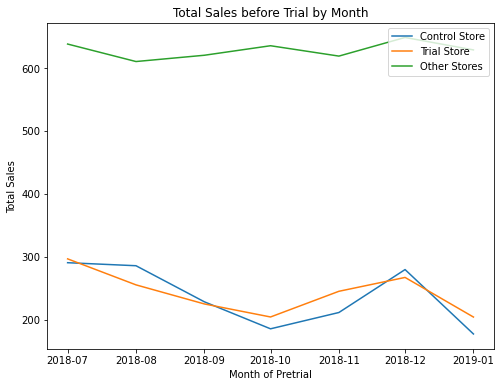

In [24]:
#plot the figure of Total Sales before Trial by Month for all 3 type stores 
plt.figure(figsize = (8, 6))
plt.plot(totSalesVisualization())
plt.title('Total Sales before Trial by Month')
plt.xlabel('Month of Pretrial')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'],loc =1);


In [25]:
# Do the same for 'nCustomers' 

# First create relevant dataframes 
def CustomersVisualization():
    controlCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'nCustomers']]
    controlCustomersPlot.set_index('TransactionMonth', inplace = True)
    controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)
    trialCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'nCustomers']]
    trialCustomersPlot.set_index('TransactionMonth', inplace = True)
    trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)
    otherCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'nCustomers']]
    otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('TransactionMonth').nCustomers.mean())
    otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)
    # Concatenate
    combineCustomersPlot = pd.concat([controlCustomersPlot, trialCustomersPlot, otherCustomersPlot], axis = 1)
    return combineCustomersPlot

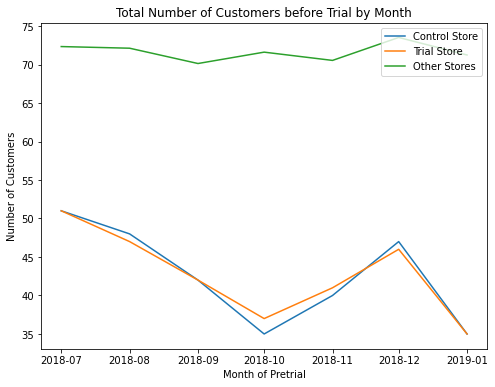

In [26]:
# Plot total number of customers for all 3 types of stores
plt.figure(figsize = (8,6))
plt.plot(CustomersVisualization())
plt.title('Total Number of Customers before Trial by Month')
plt.xlabel('Month of Pretrial')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc =1);

In [27]:
ComparePastSales(86,155)

<ipython-input-20-a6b95d91bce0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01
...,...,...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549,Other Stores,2018-09-01
3160,272,201810,430.6,44,1.159091,1.941176,4.349495,Other Stores,2018-10-01
3161,272,201811,376.2,41,1.097561,1.933333,4.324138,Other Stores,2018-11-01
3162,272,201812,403.9,47,1.000000,1.893617,4.538202,Other Stores,2018-12-01


In [28]:
ComparePastSales(86,155)['TransactionMonth'] = pd.to_datetime(ComparePastSales(86,155)['YEAR_MONTH'].astype(str), format = '%Y%m')
ComparePastSales(86,155).head()

<ipython-input-20-a6b95d91bce0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type
<ipython-input-28-241290fa5daa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ComparePastSales(86,155)['TransactionMonth'] = pd.to_datetime(ComparePastSales(86,155)['YEAR_MONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


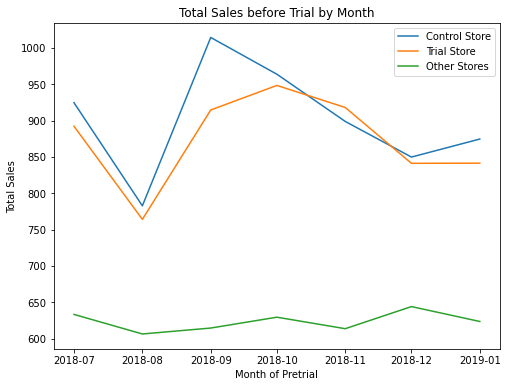

In [29]:
plt.figure(figsize = (8,6))
plt.plot(totSalesVisualization())
plt.title('Total Sales before Trial by Month')
plt.xlabel('Month of Pretrial')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'],loc =1);


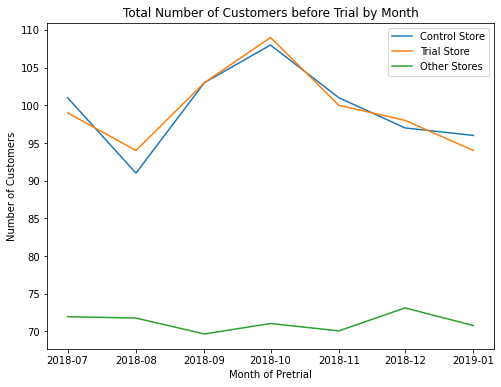

In [30]:
plt.figure(figsize = (8,6))
plt.plot(CustomersVisualization())
plt.title('Total Number of Customers before Trial by Month')
plt.xlabel('Month of Pretrial')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc =1);

In [31]:
ComparePastSales(88,40)

<ipython-input-20-a6b95d91bce0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01
...,...,...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549,Other Stores,2018-09-01
3160,272,201810,430.6,44,1.159091,1.941176,4.349495,Other Stores,2018-10-01
3161,272,201811,376.2,41,1.097561,1.933333,4.324138,Other Stores,2018-11-01
3162,272,201812,403.9,47,1.000000,1.893617,4.538202,Other Stores,2018-12-01


In [32]:
ComparePastSales(88,40)['TransactionMonth'] = pd.to_datetime(ComparePastSales(86,155)['YEAR_MONTH'].astype(str), format = '%Y%m')
ComparePastSales(88,40).head()

<ipython-input-20-a6b95d91bce0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type
<ipython-input-32-7291920e530f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ComparePastSales(88,40)['TransactionMonth'] = pd.to_datetime(ComparePastSales(86,155)['YEAR_MONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEAR_MONTH,tot_Sales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


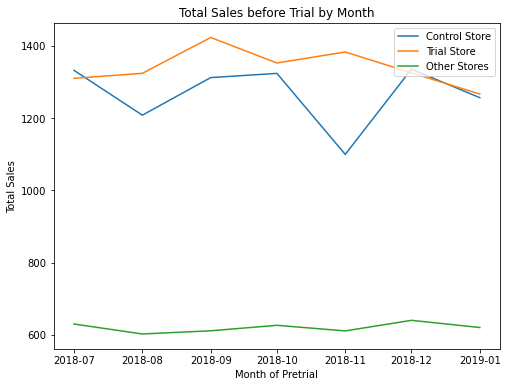

In [33]:
plt.figure(figsize = (8,6))
plt.plot(totSalesVisualization())
plt.title('Total Sales before Trial by Month')
plt.xlabel('Month of Pretrial')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'],loc =1);


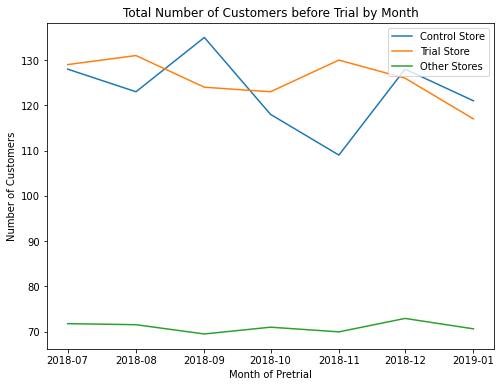

In [34]:
plt.figure(figsize = (8,6))
plt.plot(CustomersVisualization())
plt.title('Total Number of Customers before Trial by Month')
plt.xlabel('Month of Pretrial')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc =1);

Next we will compare the performance of Trial stores to Control stores during the trial period.We'll start with scaling the control store's sales to a level similar to control (multiply to ratio of trial / control) for any differences between the two stores outside of the trial period.

In [ ]:
#Starting with totoal sales
